In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=4fa3a77641fdfc79980966556ed65d9f71b5adbdf7cefcefea2ff041776a7d5f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=b345ede56c5ab3bb3d4f198c726cad5d3cc07e9039f869ad31136e378f528c3d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [96]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Tuple
from sklearn.manifold import TSNE

In [4]:
label_to_description = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Press',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [5]:
def plot_image(img: np.ndarray, title: str = '', figsize: Tuple[int, int] = None, ax: 'AxesSubplot' = None, **params) -> None:
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.axes()
    
    if title:
        ax.set_title(title)

    ax.imshow(img, **params)
    ax.axis('off')

In [6]:
def lenet(activation):
    model = keras.Sequential()
    
    model.add(layers.Conv2D(6, (5, 5), activation=activation, input_shape=(32, 32, 1)))
    model.add(layers.MaxPool2D((2, 2), 2))
    
    model.add(layers.Conv2D(16, (5, 5), activation=activation))
    model.add(layers.MaxPool2D((2, 2), 2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(120, activation=activation))
    model.add(layers.Dense(84, activation=activation))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

model = lenet('relu')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [7]:
def one_hot(arr, max_=None):
    if not max_:
        max_ = arr.max() + 1

    size = arr.size
    encoding = np.zeros((size, max_))
    encoding[np.arange(size), arr] = 1
    
    return encoding

In [8]:
def get_Fashion_MNIST():
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    X_train = np.pad(X_train, ((0, 0), (2, 2), (2, 2)), 'constant')
    X_test = np.pad(X_test, ((0, 0), (2, 2), (2, 2)), 'constant')
    
    X_train = X_train.reshape((-1, 32, 32, 1))
    X_test = X_test.reshape((-1, 32, 32, 1))
    
    y_train = one_hot(y_train)
    y_test = one_hot(y_test)
    
    return (X_train, y_train), (X_test, y_test)

In [26]:
def lenet_model(hp):
    
    hp_activation = hp.Choice('activation', ['relu', 'elu', 'tanh', 'swish'])
    
    model = lenet(hp_activation)
    
    
    hp_learning_rate = hp.Float('learning_rate', min_value=3e-4, max_value=3e-3)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])
    
    return model

----

In [27]:
(X_train, y_train), (X_test, y_test) = get_Fashion_MNIST()

This is Sandal


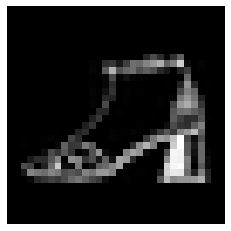

In [28]:
idx = np.random.randint(0, len(X_train))
plot_image(X_train[idx].squeeze(-1), cmap='gray')
print(f'This is {label_to_description[y_train[idx].argmax()]}')

In [32]:
tuner = kt.Hyperband(lenet_model,
                    objective='val_accuracy',
                    max_epochs=15,
                    project_name='lab3',
                    directory='drive/MyDrive')

In [33]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [34]:
tuner.search(X_train, y_train, epochs=15, 
             validation_data=(X_test, y_test), callbacks=[stop_early])

Trial 30 Complete [00h 01m 02s]
val_accuracy: 0.8992000222206116

Best val_accuracy So Far: 0.9064000248908997
Total elapsed time: 00h 14m 25s
INFO:tensorflow:Oracle triggered exit


In [35]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.get('activation'), best_hp.get('learning_rate')

('swish', 0.0014888900766078003)

In [52]:
model = lenet('swish')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate')),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])

In [53]:
history_log = model.fit(X_train, y_train, epochs=15, 
             validation_data=(X_test, y_test), batch_size=8)

Epoch 1/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.5760 - accuracy: 0.7849 - val_loss: 0.3483 - val_accuracy: 0.8717
Epoch 2/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.3104 - accuracy: 0.8824 - val_loss: 0.3059 - val_accuracy: 0.8899
Epoch 3/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.2669 - accuracy: 0.8993 - val_loss: 0.3130 - val_accuracy: 0.8873
Epoch 4/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.2385 - accuracy: 0.9111 - val_loss: 0.2902 - val_accuracy: 0.8958
Epoch 5/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.2116 - accuracy: 0.9199 - val_loss: 0.3193 - val_accuracy: 0.8997
Epoch 6/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.1988 - accuracy: 0.9249 - val_loss: 0.3111 - val_accuracy: 0.8984
Epoch 7/15
7500/7500 [==============================] - 22s 3ms/step - loss: 0.1839 - accuracy: 0.9309 - val_loss: 0.3033 - val_ac

In [57]:
model.save('drive/MyDrive/')

INFO:tensorflow:Assets written to: drive/MyDrive/assets


In [59]:
history = history_log.history

In [60]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

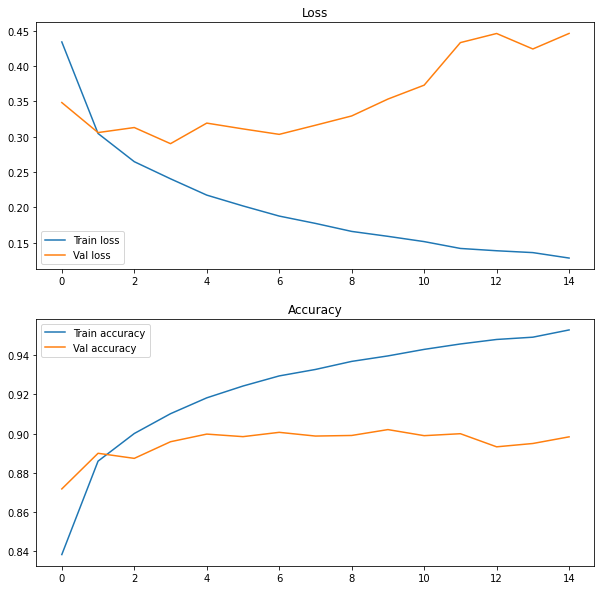

In [64]:
f, ax = plt.subplots(2, figsize=(10, 10))

ax[0].plot(history['loss'], label='Train loss')
ax[0].plot(history['val_loss'], label='Val loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history['accuracy'], label='Train accuracy')
ax[1].plot(history['val_accuracy'], label='Val accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

In [65]:
def create_feature_extractor(input_shape):
    def conv_block(input_, i):
        input_ = layers.Conv2D(8 * 2**i, kernel_size=(3, 3), activation='linear')(input_)
        input_ = layers.BatchNormalization()(input_)
        input_ = layers.Activation('relu')(input_)

        input_ = layers.Conv2D(16 * 2**i, kernel_size=(3, 3), activation='linear')(input_)
        input_ = layers.BatchNormalization()(input_)
        input_ = layers.Activation('relu')(input_)
        input_ = layers.MaxPool2D((2, 2))(input_)
        
        return input_
    
    img_in = layers.Input(shape=input_shape, name='FeatureNet_ImageInput')
    input_ = img_in
    
    for i in range(2):
        input_ = conv_block(input_, i)
    
    input_ = layers.Flatten()(input_)
    input_ = layers.Dense(32, activation='linear')(input_)
    input_ = layers.Dropout(0.5)(input_)
    input_ = layers.BatchNormalization()(input_)
    input_ = layers.Activation('relu')(input_)
    
    model = keras.Model(inputs=[img_in], outputs=[input_], name='FeatureGenerationModel')
        
    return model

feature_extractor_model = create_feature_extractor((32, 32, 1))
feature_extractor_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 

In [66]:
def create_siamese_model(feature_extractor, input_shape=(32, 32, 1)):
    img_a_in = layers.Input(shape=input_shape, name='ImageA_Input')
    img_b_in = layers.Input(shape=input_shape, name='ImageB_Input')
    
    img_a_features = feature_extractor(img_a_in)
    img_b_features = feature_extractor(img_b_in)
    
    combined_features = layers.concatenate([img_a_features, img_b_features], name='merge_features')
    
    combined_features = layers.Dense(16, activation='linear')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Activation('relu')(combined_features)
    
    combined_features = layers.Dense(4, activation='linear')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Activation('relu')(combined_features)
    
    combined_features = layers.Dense(1, activation='sigmoid')(combined_features)
    
    model = keras.Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_model')
    
    return model
        
similarity_model = create_siamese_model(feature_extractor_model, (32, 32, 1))
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
similarity_model.summary()

Model: "Similarity_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           34256       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationM

In [68]:
class SiameseGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size=16):
        self.X, self.y = data
        self.N = self.X.shape[0]
        
        self.batch_size = batch_size if batch_size > 0 else self.N
        
        self.indxs_a = np.arange(0, self.N)
        self.indxs_b = np.arange(0, self.N)
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.N / self.batch_size))
    
    def __getitem__(self, i):
        batch_start = i*self.batch_size
        batch_end = batch_start + self.batch_size
        
        idxs_a = self.indxs_a[batch_start:batch_end]
        idxs_b = self.indxs_b[batch_start:batch_end]
        
        labels_a = self.y[idxs_a].argmax(axis=1)
        labels_b = self.y[idxs_b].argmax(axis=1)
        
        res_labels = (labels_a == labels_b).astype('int')
        
        return (self.X[idxs_a], self.X[idxs_b]), res_labels
    
    
    def on_epoch_end(self):
        np.random.shuffle(self.indxs_a)
        np.random.shuffle(self.indxs_b)

In [69]:
class SiameseGenerator2(keras.utils.Sequence):
    def __init__(self, data, batch_size=32):
        self.batch_size = batch_size
        
        self.X, self.y = data

        self.labels = self.y.argmax(axis=1)
        self.N = self.X.shape[0]
        self.classes = np.unique(self.labels).size
        
        self.classes_indxs = [np.where(self.labels == category) for category in range(self.classes)]
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.N / self.batch_size))
    
    def __getitem__(self, i):
        pass
    
    def on_epoch_end(self):
        pass
    
    @staticmethod
    def __create_all_possible_pairs(labels):
        pass

In [73]:
train_generator = SiameseGenerator((X_train, y_train))
test_generator = SiameseGenerator((X_test, y_test), batch_size=-1)

In [75]:
loss_history = similarity_model.fit(train_generator, validation_data=test_generator,
                                             epochs=25)

Epoch 1/25
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2028 - mae: 0.1288 - val_loss: 0.1797 - val_mae: 0.1230
Epoch 2/25
3750/3750 [==============================] - 30s 8ms/step - loss: 0.1977 - mae: 0.1256 - val_loss: 0.1715 - val_mae: 0.1140
Epoch 3/25
3750/3750 [==============================] - 31s 8ms/step - loss: 0.1990 - mae: 0.1263 - val_loss: 0.1699 - val_mae: 0.1131
Epoch 4/25
3750/3750 [==============================] - 30s 8ms/step - loss: 0.1942 - mae: 0.1225 - val_loss: 0.1695 - val_mae: 0.1116
Epoch 5/25
3750/3750 [==============================] - 30s 8ms/step - loss: 0.1877 - mae: 0.1184 - val_loss: 0.1574 - val_mae: 0.1066
Epoch 6/25
3750/3750 [==============================] - 30s 8ms/step - loss: 0.1870 - mae: 0.1174 - val_loss: 0.1604 - val_mae: 0.1060
Epoch 7/25
3750/3750 [==============================] - 30s 8ms/step - loss: 0.1891 - mae: 0.1189 - val_loss: 0.1563 - val_mae: 0.1066
Epoch 8/25
3750/3750 [==============================] -

In [77]:
history = loss_history.history

In [79]:
history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

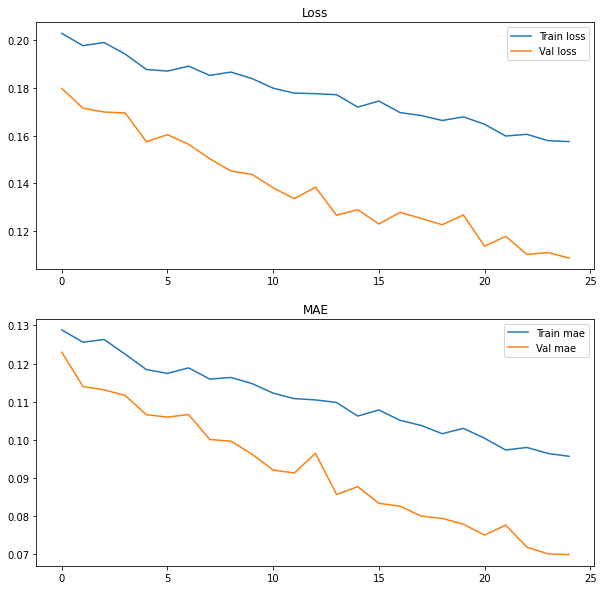

In [80]:
f, ax = plt.subplots(2, figsize=(10, 10))

ax[0].plot(history['loss'], label='Train loss')
ax[0].plot(history['val_loss'], label='Val loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history['mae'], label='Train mae')
ax[1].plot(history['val_mae'], label='Val mae')
ax[1].set_title('MAE')
ax[1].legend()

In [81]:
test_features = feature_extractor_model.predict(X_test)

In [82]:
tsne_obj = TSNE(n_components=2, init='pca', random_state=101, 
               method='barnes_hut', n_iter=500, verbose=2)
tsne_features = tsne_obj.fit_transform(test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.036s...
[t-SNE] Computed neighbors for 10000 samples in 1.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.221034
[t-SNE] Computed conditional probabilities in 0.493s
[t-SNE] Iteration 50: error = 75.7577057, gradient norm = 0.0029912 (50 iterations in 3.293s)
[t-SNE] It

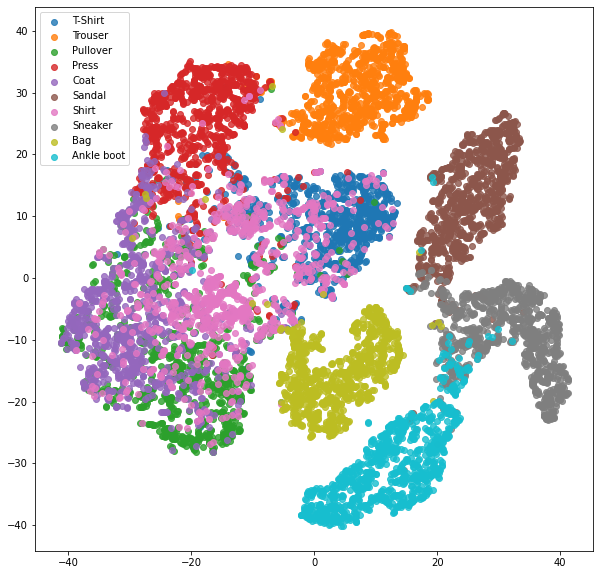

In [87]:
plt.figure(figsize=(10, 10))
test_labels = y_test.argmax(axis=1)
for label, name in label_to_description.items():
    indxs = np.where(test_labels == label)
    plt.scatter(tsne_features[indxs, 0], tsne_features[indxs, 1],
                label=name, alpha=0.8)
    
plt.legend()

In [88]:
Y_pred = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(y_test.argmax(axis=1), Y_pred.argmax(axis=1)).numpy()

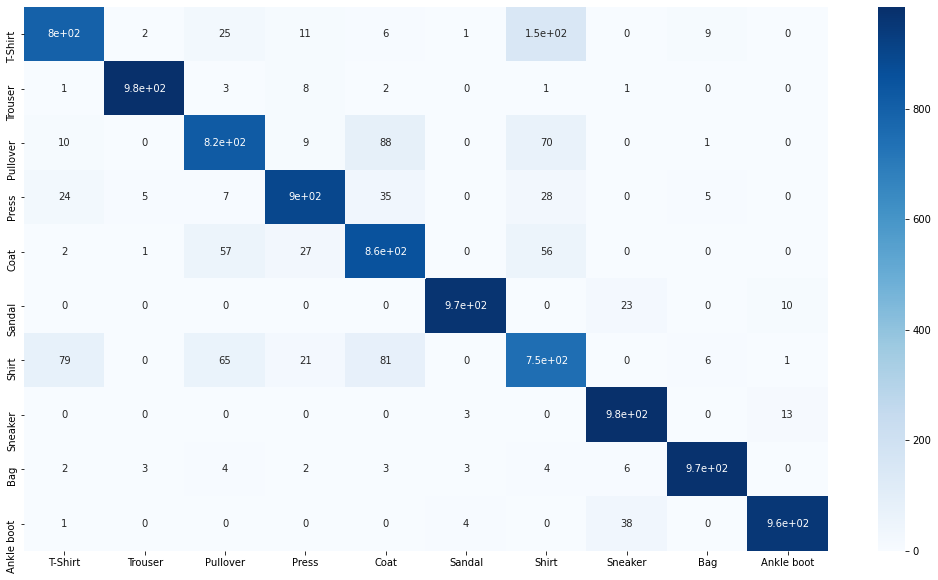

In [122]:
plt.figure(figsize=(18, 10))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues,
            xticklabels=label_to_description.values(), yticklabels=label_to_description.values());

---